# 1. Can we treat exhaustive search as a special type of beam search? Why or why not?

We can treat exhaustive search as a special type of beam search, where the beam size is equal to the size of the search space. In other words, exhaustive search is a beam search that keeps all the possible candidates at each time step, and does not prune any of them. This way, exhaustive search can guarantee to find the optimal solution, but it also has a very high computational cost and memory requirement. On the other hand, beam search is a heuristic search that keeps only a fixed number of candidates at each time step, and prunes the rest based on some scoring function. This way, beam search can reduce the computational cost and memory requirement, but it also has a risk of missing the optimal solution. Therefore, exhaustive search and beam search are two extremes of a trade-off between accuracy and efficiency. For more details and examples on exhaustive search and beam search, you can refer to [1] or [2].

# 2. Apply beam search in the machine translation problem in Section 10.7. How does the beam size affect the translation results and the prediction speed?

Beam search is a heuristic search algorithm that can be applied to the machine translation problem. The idea is to generate the most probable translation by keeping only a fixed number of candidates at each time step, and pruning the rest based on some scoring function. The beam size is a parameter that controls how many candidates are kept at each time step. The beam size affects the translation results and the prediction speed in the following ways:

- A larger beam size can improve the translation quality, because it can explore more possible translations and reduce the risk of missing the optimal one. However, a larger beam size also increases the prediction time and memory consumption, because it requires more computation and storage to evaluate and store more candidates. Therefore, a larger beam size has a trade-off between accuracy and efficiency.
- A smaller beam size can reduce the prediction time and memory consumption, because it requires less computation and storage to evaluate and store fewer candidates. However, a smaller beam size also decreases the translation quality, because it can miss some possible translations and increase the risk of choosing a suboptimal one. Therefore, a smaller beam size has a trade-off between efficiency and accuracy.

The optimal beam size depends on the specific problem domain, data characteristics, model architecture, and evaluation metrics. There is no universal rule to determine the best beam size, but some empirical studies have suggested that a beam size of around 4 to 10 can achieve good results for most machine translation tasks . For more details and examples on how to apply beam search in machine translation, you can refer to [3] or [4].

# 3. We used language modeling for generating text following user-provided prefixes in Section 9.5. Which kind of search strategy does it use? Can you improve it?

We use greedy search in Section 9.5, we can use beam search to improve it.

In [78]:
import sys
import torch.nn as nn
import torch
import warnings
import numpy as np
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
import copy
warnings.filterwarnings("ignore")

class BeamRNNLMScratch(d2l.RNNLMScratch):
    """The RNN-based language model implemented from scratch.

    Defined in :numref:`sec_rnn-scratch`"""

    def predict(self, prefix, num_preds, vocab, device=None, k=1, alpha=0.75):
        """Defined in :numref:`sec_rnn-scratch`"""
        state, outputs = [None]*k, [[vocab[prefix[0]]] for i in range(k)]
        preds = torch.cat([torch.ones(1,len(vocab))]*k)
        res,score = None, -sys.maxsize
        for i in range(len(prefix) + num_preds - 1):
            temp = []
            for j in range(k):
                X = torch.tensor([[outputs[j][-1]]], device=device)
                embs = self.one_hot(X)
                rnn_outputs, state[j] = self.rnn(embs, state[j])
                if i < len(prefix) - 1:  # Warm-up period
                    outputs[j].append(vocab[prefix[i + 1]])
                else:  # Predict num_preds steps
                    Y = self.output_layer(rnn_outputs)
                    # print(Y.shape,preds.shape)
                    Y = Y*preds[j,:]
                    # print(Y.shape)
                    temp.append(Y.reshape(-1))
            if i >= len(prefix) - 1:
                temp = torch.cat(temp)
                # print(temp.shape)
                pred, index = torch.topk(temp, k)
                # print(pred,index)
                preds = pred.reshape(-1,1)#.repeat(1,k)
                # print(preds)
                temp_outputs = []
                for ix in range(len(index)):
                    m = index[ix] // len(vocab)
                    v = index[ix] % len(vocab)
                    o = copy.deepcopy(outputs[m])
                    o.append(v.reshape(1))
                    temp_outputs.append(o)
                    seq_len = i - len(prefix)+2
                    # print(seq_len,pred[ix],torch.log(pred[ix]),-1/pow(seq_len, alpha))
                    temp_score = 1/pow(seq_len, alpha)*torch.log(pred[ix])
                    # print(temp_score,res)
                    if temp_score.item() > score:
                        res = ''.join([vocab.idx_to_token[oi] for oi in o])
                outputs = copy.deepcopy(temp_outputs)
                
        return res

'it has of the the proul in'

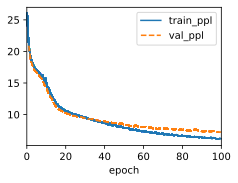

In [84]:
# data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = d2l.RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab)

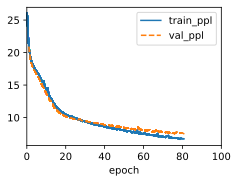

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = d2l.RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = BeamRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
# model = d2l.RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

In [82]:
model.predict('it has', 20, data.vocab, k=2)

'it has and the the the the'

In [ ]:
model.predict('it has', 20, data.vocab, k=10)